<a href="https://colab.research.google.com/github/qweliant/DS-Unit-2-Kaggle-Challenge/blob/master/DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



In [0]:
import pandas as pd
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.cluster import KMeans


In [0]:
def train_validate(X, test_set):
    train_set, validation_set = train_test_split(X, train_size=0.80, test_size=0.20, stratify=X['shot_made_flag'], random_state=2121)
    return train_set, validation_set

In [5]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [6]:
df.dtypes

game_id                      int64
game_event_id                int64
player_name                 object
period                       int64
minutes_remaining            int64
seconds_remaining            int64
action_type                 object
shot_type                   object
shot_zone_basic             object
shot_zone_area              object
shot_zone_range             object
shot_distance                int64
loc_x                        int64
loc_y                        int64
shot_made_flag               int64
game_date                   object
htm                         object
vtm                         object
season_type                 object
scoremargin_before_shot    float64
dtype: object

In [0]:
df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format=True)

In [8]:
df.dtypes

game_id                             int64
game_event_id                       int64
player_name                        object
period                              int64
minutes_remaining                   int64
seconds_remaining                   int64
action_type                        object
shot_type                          object
shot_zone_basic                    object
shot_zone_area                     object
shot_zone_range                    object
shot_distance                       int64
loc_x                               int64
loc_y                               int64
shot_made_flag                      int64
game_date                  datetime64[ns]
htm                                object
vtm                                object
season_type                        object
scoremargin_before_shot           float64
dtype: object

## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [9]:
target = 'shot_made_flag'
y_train = df[target]
y_train.value_counts(normalize = True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

# *The baseline tells me he made 52 percent of his shots*

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [10]:
df.game_date.dt.year.unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [11]:
df.game_date.dt.month.unique()

array([10, 11, 12,  1,  2,  3,  4,  5,  6])

In [0]:
df['year'] = df.game_date.dt.year
df['month'] = df.game_date.dt.month

In [0]:
test1 = df[ (( df.year.isin([2018]) ) & ( df.month.isin([10,11,12]) )) ]
test2 = df[ (( df.year.isin([2019]) ) & ( df.month.isin([1,2,3,4,5,6]) )) ]

In [0]:
test = pd.concat([test1, test2] )

In [15]:
test.shape

(1709, 22)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [16]:
df.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
game_id,13958.0,2.442837e+07,7.226620e+06,20900015.0,21200912.0,21500259.0,21700963.0,41800403.0
game_event_id,13958.0,2.704385e+02,1.699272e+02,2.0,109.0,275.5,398.0,752.0
period,13958.0,2.412380e+00,1.125828e+00,1.0,1.0,2.0,3.0,6.0
minutes_remaining,13958.0,4.727540e+00,3.331646e+00,0.0,2.0,4.0,7.0,11.0
seconds_remaining,13958.0,2.850638e+01,1.759770e+01,0.0,13.0,29.0,44.0,59.0
shot_distance,13958.0,1.760037e+01,1.029581e+01,0.0,8.0,22.0,25.0,83.0
loc_x,13958.0,-5.541625e-01,1.247219e+02,-250.0,-96.0,1.0,95.0,247.0
loc_y,13958.0,1.312580e+02,1.026666e+02,-41.0,23.0,141.0,219.0,811.0
shot_made_flag,13958.0,4.729188e-01,4.992840e-01,0.0,0.0,0.0,1.0,1.0
scoremargin_before_shot,13958.0,1.615561e+00,1.012714e+01,-39.0,-4.0,1.0,8.0,43.0


In [17]:
df.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq,first,last
player_name,13958,1,Stephen Curry,13958,NaN,NaN
shot_type,13958,2,2PT Field Goal,7135,NaN,NaN
season_type,13958,2,Regular Season,11846,NaN,NaN
shot_zone_range,13958,5,24+ ft.,6721,NaN,NaN
shot_zone_area,13958,6,Center(C),5987,NaN,NaN
shot_zone_basic,13958,7,Above the Break 3,5695,NaN,NaN
htm,13958,32,GSW,6871,NaN,NaN
vtm,13958,32,GSW,7087,NaN,NaN
action_type,13958,53,Jump Shot,6657,NaN,NaN
game_date,13958,801,2013-05-06 00:00:00,35,2009-10-28 00:00:00,2019-06-05 00:00:00


In [18]:
df.htm.unique()



array(['GSW', 'PHX', 'SAC', 'IND', 'MIL', 'CLE', 'BOS', 'DAL', 'SAS',
       'DEN', 'OKC', 'NJN', 'CHI', 'DET', 'PHI', 'MEM', 'NOH', 'LAL',
       'POR', 'MIN', 'HOU', 'MIA', 'ORL', 'ATL', 'CHA', 'LAC', 'UTA',
       'TOR', 'WAS', 'NYK', 'BKN', 'NOP'], dtype=object)

In [19]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,year,month
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,2009,10
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,2009,10
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,2009,10
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,2009,10
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,2009,10


In [20]:
df.head(5)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,year,month
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,2009,10
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,2009,10
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,2009,10
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,2009,10
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,2009,10


In [0]:
def wrangle(X):
    X = X.copy()

    home = X.htm.to_list()
    away = X.vtm.to_list()
    shot = X.shot_made_flag.to_list()

    for x in home:
        if x == 'GSW':
            X['hmct_advantage'] = 1
        else:
            X['hmct_advantage'] = 0

    for h, v in zip(home, away):
        if h == 'GSW':
            X['ops'] = v
        elif v == 'GSW':
            X['ops'] = h

    # consecutive =0
    # for s in shot
    #     if s == 1:
    #         consective += 1
    #     else:
    #         consective = 0
    #     df['consective'] = consecutive

    return X



## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [0]:

train_set, validation_set = train_validate(df, test)

In [0]:
# train_set = wrangle(train_set)
# validation_set = wrangle(validation_set)
# test = wrangle(test)

In [24]:
train_set.shape, test.shape, validation_set.shape

((11166, 22), (1709, 22), (2792, 22))

In [0]:
numbers_columns = train_set.select_dtypes(include='number').drop(target, axis=1).columns.tolist()
categorical_columns = train_set.select_dtypes(exclude='number').columns.tolist()
drop_high_cardinality = [col for col in categorical_columns if train_set[col].nunique() <= 200]
features = numbers_columns + drop_high_cardinality

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
X_train = train_set[features]
y_train = train_set[target]
X_val = validation_set[features]
y_val = validation_set[target]
X_test = test[features]

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [36]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=2121, min_samples_leaf = 2, n_jobs=-1, oob_score=False)
)

pipeline.fit(X_train, y_train)


print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.9937309690130754
Validation Accuracy: 0.6282234957020058


In [37]:
stack_cup = {
    'randomforestclassifier__max_features': range(1,20),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = stack_cup,
    n_iter=100,
    cv=9,
    verbose=10,
    return_train_score=True,
    n_jobs=-1,
    scoring = 'accuracy'
)
search.fit(X_train, y_train)

Fitting 9 folds for each of 19 candidates, totalling 171 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 19 is smaller than n_iter=100. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  81

RandomizedSearchCV(cv=9, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['player_name',
                                                                   'action_type',
                                                                   'shot_type',
                                                                   'shot_zone_basic',
                                                                   'shot_zone_area',
                                                                   'shot_zone_range',
                                                                   'htm', 'vtm',
                                                                   'season_type'],
                                                             drop_invariant=False,
                                                             handle_missing='va

## 7. Get your model's test accuracy

> (One time, at the end.)

In [0]:
from sklearn.metrics import accuracy_score
y_pred = search.predict(X_test)


In [42]:
print('Test Accuracy:', search.score(X_test, y_pred))

Test Accuracy: 1.0


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [0]:
y_pred = search.predict(X_val)

In [0]:

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns



def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    return columns, index


def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')


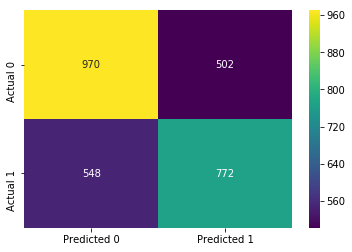

In [49]:
plot_confusion_matrix(y_val, y_pred);


In [0]:
tot = 970 + 502 + 548 + 772

In [0]:
cor = 970 + 772

In [56]:
cor/tot
# accuracy

0.6239255014326648

### Calculate precision

In [0]:
correct_shot = 772

In [0]:
predicted_correct_shot_total = 772 + 502 

In [63]:
prec = correct_shot /predicted_correct_shot_total 
print(f'Precision: {prec}')

Precision: 0.6059654631083202


### Calculate recall

In [0]:
actual_shots = 548 + 772

In [66]:
recal = correct_shot / actual_shots
recal

0.5848484848484848